In [1]:
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt

# Input space transformation (dimensionality reduction)
from sklearn.decomposition import PCA
from sklearn import random_projection
from sklearn import cluster
from sklearn.random_projection import johnson_lindenstrauss_min_dim

import utils

from clustering_adv_sample_detection import ClusterAdversarialClassifier as Classifier

## Testing Cluster Adversarial Classifier

### Load Data

In [2]:
# MNIST
X_train, y_train, X_test, y_test = utils.load_mnist()

# Perfomance on MNIST with PCA transform, FC NN, and eps=3e-2: 
# Wall time: 1min 33s
# Cluster Classifier Accuracy on clean data: 97.930
# Cluster Classifier Accuracy on adversarial data: 92.460
# Percentage of input data flagged as suspicious by detector: 45.670

# Fashion MNIST
#X_train, y_train, X_test, y_test = utils.load_fashion_mnist()

# Perfomance on Fashion MNIST with PCA transform, FC NN, and eps=3e-2: 
# Wall time: 2min
# Cluster Classifier Accuracy on clean data: 87.760
# Cluster Classifier Accuracy on adversarial data: 79.280
# Percentage of input data flagged as suspicious by detector: 46.340

# CIFAR-10
#X_train, y_train, X_test, y_test = utils.load_cifar10()

# Perfomance on CIFAR-10 with PCA transform, FC NN, and eps=3e-2:  
# Wall time: 8min 28s
# Cluster Classifier Accuracy on clean data: 51.990
# Cluster Classifier Accuracy on adversarial data: 43.500
# Percentage of input data flagged as suspicious by detector: 55.520

### Train Base Neural Network

In [3]:
from model import My_VGG as Model

In [4]:
model = Model(in_channels=1, num_classes=10)

c:\users\jason\appdata\local\programs\python\python39\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch 0 - Training loss: 0.18234696854335336
Epoch 1 - Training loss: 0.08361781710163899
Epoch 2 - Training loss: 0.05977548448781294
Epoch 3 - Training loss: 0.054586552963793944
Epoch 4 - Training loss: 0.04260683313866482

Training Time (in minutes) = 1.9497706254323324
Predicted Digit = 9
Number Of Images Tested = 10000

Model Accuracy = 0.9923


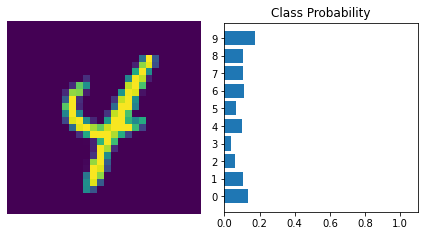

In [5]:
# Now let's start training the network
# input_size = X_train.shape[1]
# hidden_sizes = [128, 64]
# output_size = 10

# model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
#                       nn.ReLU(),
#                       nn.Linear(hidden_sizes[0], hidden_sizes[1]),
#                       nn.ReLU(),
#                       nn.Linear(hidden_sizes[1], output_size),
#                       nn.LogSoftmax(dim=1))

model = utils.train_model(model, X_train, X_test, y_train, y_test, epochs=5)

### Input Space (Dimensionality Reduction) Transforms - optional

In [6]:
# SKLearn method for determining a "minimum" number of components to reduce the dataset to
n_comp = johnson_lindenstrauss_min_dim(X_train.shape[0], eps=.99)

# Control (no transform): Wall time: 2min 53s, clean: 0.9733, adv: 0.8829
#transformer = None

# GaussianRandomProjection(n_components=374): Wall time: 1min 47s, clean: 0.9737, adv: 0.8892
# 2nd run: Wall time: 1min 52s, clean: 0.9727, adv: 0.911
#transformer = random_projection.GaussianRandomProjection(n_components=n_comp)

# SparseRandomProjection(n_components=374): Wall time: 1min 46s, clean: 0.9744, adv: 0.9247
# 2nd run: Wall time: 1min 47s, clean: 0.9706, adv: 0.8998
#transformer = random_projection.SparseRandomProjection(n_components=n_comp)

# PCA(n_components=374): Wall time: 1min 53s, clean: 0.9783, adv: 0.9137
# 2nd run: Wall time: 1min 32s, clean: 0.9757, adv: 0.9028
transformer = PCA(n_components=n_comp)

# FeatureAgglomeration(n_clusters=10):  Wall time: 46.2 s, clean: 0.8512, adv: 0.782
#transformer = cluster.FeatureAgglomeration(n_clusters=10)

### Fitting and scoring the classifier on clean data

In [7]:
classifier = Classifier(model, transformer)

%time classifier.fit(X_train, y_train)
print("Cluster Classifier Accuracy on clean data: %.3f" % (classifier.score(X_test, y_test) * 100.0))

Wall time: 1min 45s
Cluster Classifier Accuracy on clean data: 98.240


### Scoring the classifier on adversarial data

In [8]:
eps = 1e-1

test_dataloader = utils.create_dataloader(X_test, y_test)
adv_test_data = utils.add_adversarial_noise(model, test_dataloader, eps=eps)

In [9]:
print("Cluster Classifier Accuracy on adversarial data: %.3f" % (classifier.score(adv_test_data, y_test) * 100.0))
print("Percentage of input data flagged as suspicious by detector: %.3f" % (classifier.proportion_flagged * 100))

Cluster Classifier Accuracy on adversarial data: 90.520
Percentage of input data flagged as suspicious by detector: 50.000


In [10]:
utils.eval_model(model, adv_test_data, y_test)

Number Of Samples Tested = 10000

Model Accuracy = 0.5524


## Baseline Method - Adversarial Training

### Generate adversarial data

In [11]:
train_dataloader = utils.create_dataloader(X_train, y_train)
adv_train_data = utils.add_adversarial_noise(model, train_dataloader, eps=eps)

In [12]:
baseline_train_data = np.concatenate((X_train, adv_train_data), axis=0)
baseline_train_labels = np.concatenate((y_train, y_train), axis=0)

In [13]:
baseline_test_data = np.concatenate((X_test, adv_test_data), axis=0)
baseline_test_labels = np.concatenate((y_test, y_test), axis=0)

### Train model with mix of clean and adversarial data

In [14]:
baseline_model = Model(in_channels=1, num_classes=10)

Epoch 0 - Training loss: 0.12517992927050217
Epoch 1 - Training loss: 0.05849468285732437
Epoch 2 - Training loss: 0.04563838998785553
Epoch 3 - Training loss: 0.03493964502741971
Epoch 4 - Training loss: 0.028309420261175305

Training Time (in minutes) = 3.6915702978769938
Predicted Digit = 5
Number Of Images Tested = 20000

Model Accuracy = 0.99255


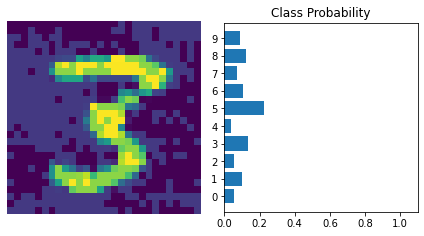

In [15]:
baseline_model = utils.train_model(baseline_model, baseline_train_data, baseline_test_data, baseline_train_labels, baseline_test_labels, epochs=5)

In [16]:
print("Baseline classifier on clean test data: ")
utils.eval_model(baseline_model, X_test, y_test)
print("Baseline classifier on adversarial test data: ")
utils.eval_model(baseline_model, adv_test_data, y_test)

Baseline classifier on clean test data: 
Number Of Samples Tested = 10000

Model Accuracy = 0.992
Baseline classifier on adversarial test data: 
Number Of Samples Tested = 10000

Model Accuracy = 0.9931
